#### IMPORTING NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import copy
import statistics
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

from kde_ebm import mixture_model
from kde_ebm import mcmc
from kde_ebm import plotting
from kde_ebm import datasets

#### SYNTHETIC BIOMARKERS DATA

In [30]:
X, Y, biomarker_name, condition_name = datasets.load_synthetic('synthetic_1500_10.csv')
X = X[:,:6]
biomarker_name = biomarker_name[:6]

In [31]:
X_ = pd.DataFrame(X,columns=biomarker_name)
Y_ = pd.DataFrame(Y,columns=['Condition'])

Y_Name = Y_.apply(lambda x : condition_name[x])
Y_Name.rename(columns={'Condition': 'Condition Name'}, inplace=True)

In [32]:
df = pd.concat((X_,Y_Name,Y_),axis=1)
df.head()

,BM1,BM2,BM3,BM4,BM5,BM6,Condition Name,Condition
0,-0.692,-0.190,1.217,-1.142,0.082,-0.356,CN,0
1,0.199,-0.238,-0.156,0.627,0.288,0.554,CN,0
2,-0.668,1.080,1.161,0.399,0.070,1.554,AD,1
3,1.091,-0.796,0.012,0.705,0.052,3.934,CN,0
4,1.195,2.981,4.020,2.057,3.439,2.455,AD,1


In [33]:
df.shape

(1500, 8)

#### HISTOGRAM OF BIOMARKER VALUES IN AD VS CN SUBPOPULATION

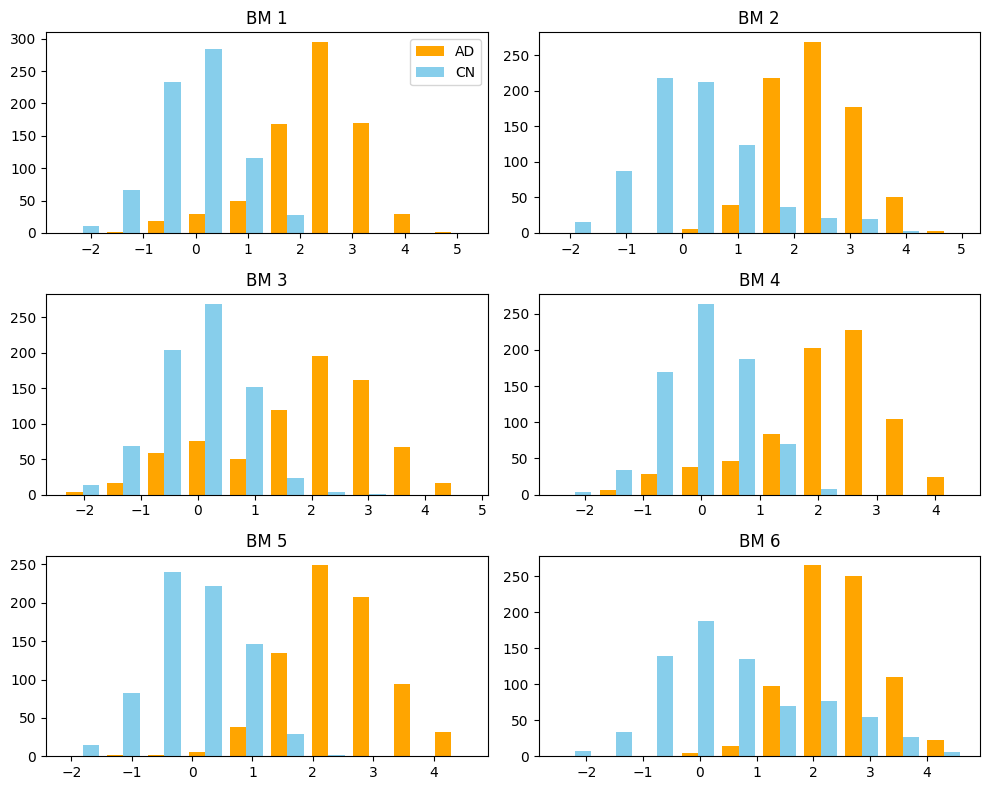

In [36]:
fig,ax = plt.subplots(3,2,figsize=(10,8))
for biomarker_number in range(len(biomarker_name)):
    ad_data = df[df['Condition Name']=='AD'].iloc[:,biomarker_number]
    cn_data = df[df['Condition Name']=='CN'].iloc[:,biomarker_number]
    ax[biomarker_number//2,biomarker_number%2].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','skyblue'])
    ax[biomarker_number//2,biomarker_number%2].set_title('BM '+ str(biomarker_number+1))
ax[0,0].legend()
fig.tight_layout()

#### FITTING MIXTURE MODELS

In [37]:
def EM(X,number_of_clusters=2,number_of_iterations = 300):

    iteration_nums = []
    likelihood = []
    
    means = np.linspace(min(X),max(X),number_of_clusters)
    stds = np.ones(number_of_clusters)
    weights = np.full(number_of_clusters,1.0/number_of_clusters)

    for iteration in range(1,number_of_iterations):
        contribution = []
        
        for i in range(number_of_clusters):
            contribution.append(weights[i]*norm.pdf(X,means[i],stds[i]))
    
        contribution = np.array(contribution)/np.sum(contribution,axis=0)
        
        for i in range(number_of_clusters):
            weights[i] = np.mean(contribution[i])
            means[i] = np.sum(contribution[i]*X)/np.sum(contribution[i])
            stds[i] = np.sqrt(np.sum(contribution[i]*(X - means[i])**2)/np.sum(contribution[i]))

        # log_likelihood = 0
        # for data_point in X:
        #     probability = 0
        #     for i in range(number_of_clusters):
        #         probability+=weights[i]*norm.pdf(data_point,means[i],stds[i])
        #     log_likelihood+=np.log(probability)

        log_likelihood = np.sum(np.log(np.sum([weights[i]*norm.pdf(X,means[i],stds[i]) for i in range(2)],axis=0)))
        
        if iteration>10 and np.array_equal(np.full(10,np.round(log_likelihood,2)),np.round(likelihood[-10:],2)):
            break
        else:
            likelihood.append(log_likelihood)
            iteration_nums.append(iteration)

    return means,stds,weights

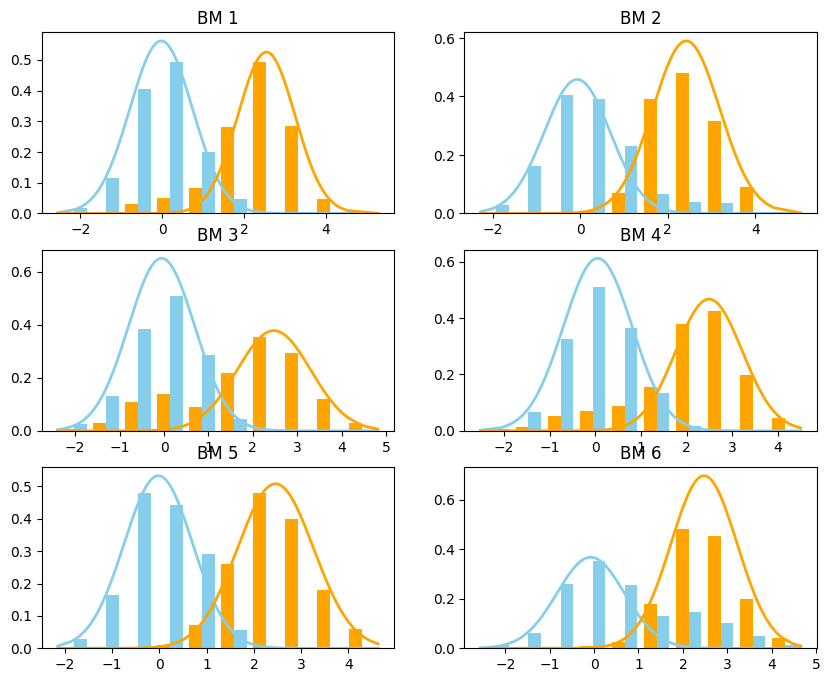

In [38]:
number_of_biomarkers = len(biomarker_name)
fig,ax = plt.subplots(3,2,figsize=(10,8))
gmm_parameters = {}

for biomarker_number in range(number_of_biomarkers):
    
    biomarker_data = df.iloc[:,biomarker_number]
    means,stds,weights = EM(biomarker_data)

    # Original Data with Labels
    ad_data = df[df['Condition Name']=='AD'].iloc[:,biomarker_number]
    cn_data = df[df['Condition Name']=='CN'].iloc[:,biomarker_number]
    x_index,y_index = biomarker_number//2,biomarker_number%2

    ax[x_index,y_index].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','skyblue'],density=True,bins=10)
    gmm_parameters['BM'+ str(biomarker_number+1)] = [weights,means,stds]

    # Fitted GMM model
    X_sorted = np.sort(biomarker_data)
    cn_density_estimation = weights[0]*norm.pdf(X_sorted, means[0],stds[0])
    ad_density_estimation = weights[1]*norm.pdf(X_sorted, means[1],stds[1])
    density_estimation = (cn_density_estimation + ad_density_estimation)
    ax[x_index,y_index].plot(X_sorted,cn_density_estimation*2, color='skyblue', linewidth=2)
    ax[x_index,y_index].plot(X_sorted,ad_density_estimation*2, color='orange', linewidth=2)
    ax[x_index,y_index].set_title('BM '+ str(biomarker_number+1))

In [39]:
for biomarker in gmm_parameters:
    print(biomarker,'\t',gmm_parameters[biomarker])

BM1 	 [array([0.53962726, 0.46037274]), array([-0.02408427,  2.54835651]), array([0.76699406, 0.6998623 ])]
BM2 	 [array([0.43348548, 0.56651452]), array([-0.07209068,  2.42215669]), array([0.75452473, 0.76600475])]
BM3 	 [array([0.60755032, 0.39244968]), array([-0.05470735,  2.47510661]), array([0.74583221, 0.82924103])]
BM4 	 [array([0.57513456, 0.42486544]), array([0.05155556, 2.48710102]), array([0.75025813, 0.72573875])]
BM5 	 [array([0.48531439, 0.51468561]), array([-0.02283423,  2.45811374]), array([0.7262544 , 0.80793393])]
BM6 	 [array([0.34924536, 0.65075464]), array([-0.07709514,  2.47608294]), array([0.75857692, 0.74571952])]


#### DEFINING NECESSARY FUNCTIONS

In [101]:
def patient_likelihood_at_K(individual_data,event_sequence,K,gmm_parameters):

    ''' If a patient is at the position k in the progression model,
        where events upto k have occured and rest have not'''
    
    event_position = list(event_sequence).index(K)
    events_occured = event_sequence[:event_position+1]
    events_not_occured = event_sequence[event_position+1:]
    likelihood = 1
    mean = []
    stds = []
    values = []
    
    for event in events_occured:
        biomarker_value = individual_data[event]
        high_mean = gmm_parameters[event][1][1]
        high_std = gmm_parameters[event][2][1]
        likelihood*=norm.pdf(biomarker_value,high_mean,high_std)
        
    for event in events_not_occured:
        biomarker_value = individual_data[event]
        low_mean = gmm_parameters[event][1][0]
        low_std = gmm_parameters[event][2][0]
        likelihood*=norm.pdf(biomarker_value,low_mean,low_std)

    print(likelihood)
    return likelihood

def patient_likelihood(individual_data,event_sequence,gmm_parameters):

    ''' Integrating out the hidden variable K '''
    individual_data_likelihood=0
    uniform_prior = 1.0/len(event_sequence)
    for event in event_sequence:
        likelihood_at_k = patient_likelihood_at_K(individual_data,event_sequence,event,gmm_parameters)
        individual_data_likelihood+=uniform_prior*likelihood_at_k
    return np.log(individual_data_likelihood)

def data_likelihood(patients_data,event_sequence,gmm_parameters):
    data_likelihood = 0
    for patient_number in range(len(patients_data)):
        individual_data = patients_data[patient_number]
        processed_data = {}
        for biomarker_number in range(len(individual_data)):
            processed_data['BM'+ str(biomarker_number+1)] = individual_data[biomarker_number].item()
        data_likelihood+=patient_likelihood(processed_data,event_sequence,gmm_parameters)
        
    return data_likelihood

In [102]:
ad_data = df[df['Condition']==1]
X = ad_data.iloc[:,:6].to_numpy()

print('Patient 1 data:',X[0])
print('Patient 2 data:',X[1])

Patient 1 data: [-0.668  1.08   1.161  0.399  0.07   1.554]
Patient 2 data: [1.195 2.981 4.02  2.057 3.439 2.455]


In [103]:
sequence = ['BM6','BM5','BM2','BM1','BM4','BM3'] 	 	
print('Sequence: ',sequence,'\t','Likelihood:',data_likelihood([X[0]],sequence,gmm_parameters),'\n')

0.0005534790860216704
6.355713401094198e-06
4.327376080265874e-06
1.7490605349361795e-10
3.2076713943498114e-12
3.1028898727663682e-12
Sequence:  ['BM6', 'BM5', 'BM2', 'BM1', 'BM4', 'BM3'] 	 Likelihood: -9.271927950595694 



In [94]:
sequence_1 = ['BM6','BM5','BM2','BM1','BM4','BM3'] 	
sequence_2 = ['BM6','BM2','BM5','BM1','BM4','BM3'] 	

print('Sequence: ',sequence_1,'\t','Likelihood:',data_likelihood(X,sequence_1,gmm_parameters),'\n')
print('Sequence: ',sequence_2,'\t','Likelihood:',data_likelihood(X,sequence_2,gmm_parameters),'\n')

Sequence:  ['BM6', 'BM5', 'BM2', 'BM1', 'BM4', 'BM3'] 	 Likelihood: -7814.089081378078 

Sequence:  ['BM6', 'BM2', 'BM5', 'BM1', 'BM4', 'BM3'] 	 Likelihood: -7789.0687133889505 



In [13]:
current_sequence = copy.deepcopy(biomarker_name)

current_likelihood = data_likelihood(X,sequence_1,gmm_parameters)
print('Current Sequence: ',sequence_1,'\t','Likelihood: ',current_likelihood)

current_likelihood = data_likelihood(X,sequence_2,gmm_parameters)
print('Current Sequence: ',sequence_2,'\t','Likelihood: ',current_likelihood)

Current Sequence:  ['BM1' 'BM2' 'BM3' 'BM4'] 	 Likelihood:  -5237.193301772001
Current Sequence:  ['BM1' 'BM3' 'BM2' 'BM4'] 	 Likelihood:  -5267.9056278461585


#### GREEDY ASCENT ALGORITHM

In [14]:
sequences = {}
iterations = 50

ml_sequence = copy.deepcopy(biomarker_name)
ml_likelihood = data_likelihood(X,ml_sequence,gmm_parameters)

for iteration_number in tqdm(range(iterations)):
    new_sequence = copy.deepcopy(current_sequence)
    index_1, index_2 = random.sample(range(len(new_sequence)), 2)
    new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1] 
    new_likelihood = data_likelihood(X,new_sequence,gmm_parameters)
    if new_likelihood>ml_likelihood:
        ml_likelihood=new_likelihood
        ml_sequence=new_sequence
        sequences[tuple(new_sequence.tolist())]=new_likelihood

for sequence in sequences:
    print('Sequence: ',sequence,'\t','Likelihood: ',sequences[sequence])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:48<00:00,  2.17s/it]

Sequence:  ('BM1', 'BM2', 'BM4', 'BM3') 	 Likelihood:  -5209.701554726087
Sequence:  ('BM3', 'BM2', 'BM1', 'BM4') 	 Likelihood:  -5206.413535408413
Sequence:  ('BM2', 'BM1', 'BM3', 'BM4') 	 Likelihood:  -5181.91598872149


#### MARKOV CHAIN MONTE CARLO ALGORITHM

In [ ]:
iterations = 25
current_sequence = copy.deepcopy(ml_sequence)
current_likelihood = copy.deepcopy(ml_likelihood)
final_sequences = []

for iteration_number in tqdm(range(iterations)):
    new_sequence = copy.deepcopy(current_sequence)
    index_1, index_2 = random.sample(range(len(new_sequence)), 2)
    new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1] 
    new_likelihood = data_likelihood(X,new_sequence,gmm_parameters)
    check = np.exp(new_likelihood - current_likelihood)
    if random.random()<=check:
        current_sequence=new_sequence
        current_likelihood=new_likelihood
    final_sequences.append(current_sequence.tolist())

for sequence in final_sequences:
    print(sequence)

#### GREEDY ASCENT TRACES

In [ ]:
number_of_iterations = 50
n_initial = 5
likelihoods = []
for n in tqdm(range(n_initial)):
    likelihood = []
    final_sequence = []
    sequence = copy.deepcopy(biomarker_name)
    random.shuffle(sequence)
    ml_likelihood = data_likelihood(X,sequence,gmm_parameters)
    for iteration_number in range(iterations):
        index_1, index_2 = random.sample(range(len(sequence)), 2)
        new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1] 
        new_likelihood = data_likelihood(X,new_sequence,gmm_parameters)
        if new_likelihood>ml_likelihood:
            ml_likelihood=new_likelihood
            sequence=new_sequence
        likelihood.append(ml_likelihood)
    final_sequence.append(sequence)
    likelihoods.append(likelihood)

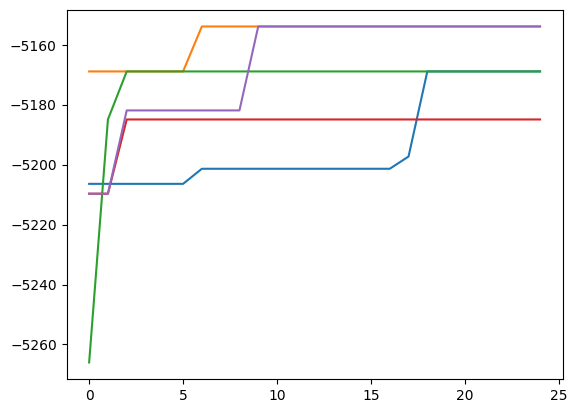

In [53]:
for values in likelihoods:
    plt.plot(values)
    
plt.show()

#### POSITIONAL VARIANCE DIAGRAM

In [78]:
events = [number for number in range(1,X.shape[1]+1)]
transposed = np.array(final_sequences).T
most_probable_sequence = [str(statistics.mode(x)) for x in transposed]

Text(0.5, 0, 'Event Order')

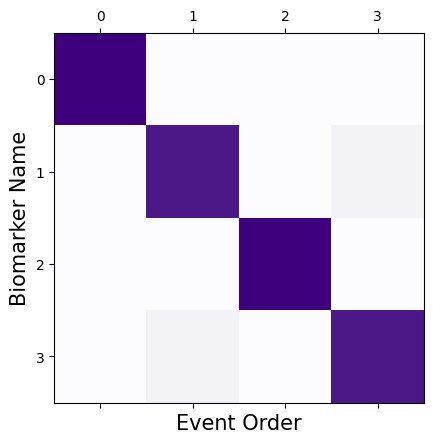

In [115]:
confusion_matrix_values = np.zeros((len(events),len(events)))
confusion_matrix_values
for column in range(len(events)):
    for row in range(len(events)):
        biomarker = most_probable_sequence[row]
        count = np.sum(transposed[column]==biomarker)
        confusion_matrix_values[row][column]=count

fig, ax = plt.subplots()

ax.matshow(confusion_matrix_values, cmap=plt.cm.Purples)
ax.set_xticks([0,1,2,3],events,minor=True)
ax.set_yticks([0,1,2,3],most_probable_sequence,minor=True) 
ax.grid(False)
ax.set_ylabel('Biomarker Name', fontsize=15)
ax.set_xlabel('Event Order', fontsize=15)